In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(50))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs) #from PdM
    #model = conv2DNet_6(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  66.43333333333334
	 Validation accuracy  55.0
	 Test accuracy  52.2
	 Epoch Loss  132.33563232421875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  76.2
	 Validation accuracy  51.875
	 Test accuracy  55.1
	 Epoch Loss  109.1463394165039
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  83.76666666666667
	 Validation accu

Epoch Number :  23
	 Training accuracy:  96.4
	 Validation accuracy  67.5
	 Test accuracy  72.0
	 Epoch Loss  6.609125137329102
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  96.83333333333333
	 Validation accuracy  70.0
	 Test accuracy  71.9
	 Epoch Loss  3.203160285949707
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  97.2
	 Validation accuracy  66.25
	 Test accuracy  72.9
	 Epoch Loss  1.7891892194747925
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])


data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  96.93333333333334
	 Validation accuracy  65.625
	 Test accuracy  72.1
	 Epoch Loss  0.19165828824043274
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  96.96666666666667
	 Validation accuracy  65.625
	 Test accuracy  72.1
	 Epoch Loss  0.19033367931842804
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  96.96666666666667
	 Validat

Epoch Number :  20
	 Training accuracy:  98.06666666666666
	 Validation accuracy  68.125
	 Test accuracy  74.1
	 Epoch Loss  0.07481172680854797
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  98.06666666666666
	 Validation accuracy  68.75
	 Test accuracy  73.9
	 Epoch Loss  0.06375554203987122
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  98.13333333333334
	 Validation accuracy  68.75
	 Test accuracy  73.8
	 Epoch Loss  0.054489586502313614
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 5

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  98.2
	 Validation accuracy  68.75
	 Test accuracy  73.0
	 Epoch Loss  0.0029935312923043966
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  98.23333333333333
	 Validation accuracy  70.0
	 Test accuracy  72.9
	 Epoch Loss  0.002667051274329424
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  98.23333333333333
	 Validation accuracy 

Epoch Number :  17
	 Training accuracy:  97.8
	 Validation accuracy  63.125
	 Test accuracy  61.0
	 Epoch Loss  0.12791839241981506
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  97.8
	 Validation accuracy  63.75
	 Test accuracy  61.2
	 Epoch Loss  0.10689692199230194
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  97.8
	 Validation accuracy  63.75
	 Test accuracy  61.2
	 Epoch Loss  0.09075051546096802
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  97.9
	 Validation accuracy  66.875
	 Test accuracy  62.5
	 Epoch Loss  0.004450539126992226
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  97.93333333333334
	 Validation accuracy  67.5
	 Test accuracy  62.8
	 Epoch Loss  0.003946199081838131
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  97.86666666666666
	 Validation accuracy 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  97.8
	 Validation accuracy  77.5
	 Test accuracy  73.8
	 Epoch Loss  0.14479239284992218
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  97.76666666666667
	 Validation accuracy  78.125
	 Test accuracy  74.0
	 Epoch Loss  0.11930954456329346
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  97.73333333333333
	 Validation accuracy  78.125
	 Test accuracy  74.2
	 Epoch Loss  0.09911861270666122
data_targe

Epoch Number :  37
	 Training accuracy:  98.0
	 Validation accuracy  78.125
	 Test accuracy  74.2
	 Epoch Loss  0.0052832732908427715
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  98.03333333333333
	 Validation accuracy  78.125
	 Test accuracy  74.3
	 Epoch Loss  0.004671265836805105
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  98.03333333333333
	 Validation accuracy  78.125
	 Test accuracy  74.3
	 Epoch Loss  0.004142913036048412
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  97.7
	 Validation accuracy  69.375
	 Test accuracy  62.2
	 Epoch Loss  0.4046340584754944
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  97.73333333333333
	 Validation accuracy  69.375
	 Test accuracy  62.9
	 Epoch Loss  0.31909462809562683
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  97.8
	 Validation accuracy  68.75
	 Test 

Epoch Number :  34
	 Training accuracy:  98.2
	 Validation accuracy  72.5
	 Test accuracy  64.2
	 Epoch Loss  0.009776466526091099
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  98.16666666666667
	 Validation accuracy  71.875
	 Test accuracy  64.4
	 Epoch Loss  0.00863791536539793
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  98.16666666666667
	 Validation accuracy  72.5
	 Test accuracy  64.4
	 Epoch Loss  0.007640449330210686
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targe

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  97.46666666666667
	 Validation accuracy  54.375
	 Test accuracy  70.8
	 Epoch Loss  2.162680149078369
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  97.83333333333333
	 Validation accuracy  54.375
	 Test accuracy  70.3
	 Epoch Loss  1.44911527633667
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  97.9
	 Validation accuracy  54.375

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  98.2
	 Validation accuracy  55.625
	 Test accuracy  70.1
	 Epoch Loss  0.019638918340206146
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  98.2
	 Validation accuracy  55.625
	 Test accuracy  70.2
	 Epoch Loss  0.01718730665743351
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  98.23333333333333
	 Validation accuracy  55.625
	 Test accuracy  70.1
	 Epoch Loss  0.015022707171738148
data_target torch.S

Epoch Number :  4
	 Training accuracy:  98.3
	 Validation accuracy  78.75
	 Test accuracy  75.8
	 Epoch Loss  13.187607765197754
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  93.03333333333333
	 Validation accuracy  80.625
	 Test accuracy  74.6
	 Epoch Loss  12.442404747009277
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  98.36666666666666
	 Validation accuracy  73.125
	 Test accuracy  75.5
	 Epoch Loss  8.779138565063477
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  98.7
	 Validation accuracy  73.125
	 Test accuracy  79.2
	 Epoch Loss  0.026615837588906288
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  98.7
	 Validation accuracy  73.75
	 Test accuracy  79.3
	 Epoch Loss  0.023249460384249687
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  98.73333333333333
	 Validation accuracy  73.125
	 Te

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  87.13333333333334
	 Validation accuracy  90.0
	 Test accuracy  67.8
	 Epoch Loss  84.61156463623047
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  93.46666666666667
	 Validation accuracy  77.5
	 Test accuracy  71.9
	 Epoch Loss  45.10858154296875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  97.13333333333334
	 Validation accuracy  78.125
	 Test accuracy  70.2
	 Epoch Loss  22.16228485107422
data_tar

Epoch Number :  24
	 Training accuracy:  98.63333333333334
	 Validation accuracy  71.25
	 Test accuracy  73.2
	 Epoch Loss  0.033413924276828766
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  98.7
	 Validation accuracy  71.25
	 Test accuracy  73.4
	 Epoch Loss  0.02902119792997837
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  98.73333333333333
	 Validation accuracy  71.25
	 Test accuracy  73.4
	 Epoch Loss  0.025472454726696014
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targ

Epoch Number :  47
	 Training accuracy:  98.66666666666667
	 Validation accuracy  71.25
	 Test accuracy  73.7
	 Epoch Loss  0.0018849329790100455
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  98.7
	 Validation accuracy  71.25
	 Test accuracy  73.7
	 Epoch Loss  0.0016822514589875937
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  98.66666666666667
	 Validation accuracy  71.25
	 Test accuracy  73.7
	 Epoch Loss  0.0014985777670517564
Repetition 8
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 2

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  98.6
	 Validation accuracy  65.0
	 Test accuracy  68.6
	 Epoch Loss  0.11935189366340637
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  98.6
	 Validation accuracy  65.0
	 Test accuracy  68.6
	 Epoch Loss  0.102338507771492
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  98.6
	 Validation accuracy  65.0
	 Test accuracy  68.6
	 Ep

Epoch Number :  44
	 Training accuracy:  98.7
	 Validation accuracy  65.625
	 Test accuracy  68.3
	 Epoch Loss  0.005611953791230917
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  98.63333333333334
	 Validation accuracy  66.875
	 Test accuracy  68.2
	 Epoch Loss  0.00496663386002183
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  98.63333333333334
	 Validation accuracy  66.25
	 Test accuracy  68.0
	 Epoch Loss  0.00439652381464839
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_tar

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  99.16666666666667
	 Validation accuracy  72.5
	 Test accuracy  74.8
	 Epoch Loss  0.13025031983852386
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  99.16666666666667
	 Validation accuracy  72.5
	 Test accuracy  74.8
	 Epoch Loss  0.10946353524923325
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  99.13333333333334
	 Validation 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  99.2
	 Validation accuracy  71.25
	 Test accuracy  75.5
	 Epoch Loss  0.004992988891899586
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  99.1
	 Validation accuracy  71.25
	 Test accuracy  75.6
	 Epoch Loss  0.004399847239255905
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  99.13333333333334
	 Validation accuracy  71.25
	 Test accuracy  75.6
	 Epoch Loss  0.0038899537175893784
data_target torch.Si

Epoch Number :  14
	 Training accuracy:  98.8
	 Validation accuracy  65.625
	 Test accuracy  73.1
	 Epoch Loss  0.13442334532737732
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  98.8
	 Validation accuracy  65.625
	 Test accuracy  72.9
	 Epoch Loss  0.11001913249492645
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  98.8
	 Validation accuracy  64.375
	 Test accuracy  73.1
	 Epoch Loss  0.09083294123411179
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
dat

Epoch Number :  37
	 Training accuracy:  98.83333333333333
	 Validation accuracy  69.375
	 Test accuracy  73.2
	 Epoch Loss  0.004546985030174255
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  98.9
	 Validation accuracy  69.375
	 Test accuracy  73.2
	 Epoch Loss  0.004031855147331953
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  98.9
	 Validation accuracy  69.375
	 Test accuracy  73.2
	 Epoch Loss  0.003567660227417946
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.6896352171897888
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.5290055274963379
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.4159925878047943
data_target torch.Size([3000])
data_input t

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.014785909093916416
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.013066191226243973
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.011560794897377491
data_target torch.Size([3000])
data_i

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  98.7
	 Validation accuracy  76.25
	 Test accuracy  75.6
	 Epoch Loss  0.6046932339668274
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  98.66666666666667
	 Validation accuracy  75.625
	 Test accuracy  75.7
	 Epoch Loss  0.440753698348999
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  98.73333333333333
	 Validation accuracy  76.2

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  98.83333333333333
	 Validation accuracy  75.0
	 Test accuracy  75.0
	 Epoch Loss  0.011341006495058537
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  98.83333333333333
	 Validation accuracy  75.0
	 Test accuracy  74.9
	 Epoch Loss  0.009975379332900047
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  98.83333333333333
	 Validation accuracy  75.0
	 Test accuracy  74.9
	 Epoch Loss  0.00880809780210256

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  98.93333333333334
	 Validation accuracy  66.875
	 Test accuracy  78.2
	 Epoch Loss  7.3711981773376465
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  98.86666666666666
	 Validation accuracy  68.75
	 Test accuracy  77.6
	 Epoch Loss  3.5220606327056885
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  98.7
	 Validation accuracy  66.875
	 Test accuracy  73.8
	 Epoch Loss  2.466848373413086
data_target torc

Epoch Number :  28
	 Training accuracy:  99.03333333333333
	 Validation accuracy  74.375
	 Test accuracy  77.3
	 Epoch Loss  0.024348335340619087
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  99.03333333333333
	 Validation accuracy  74.375
	 Test accuracy  77.6
	 Epoch Loss  0.021259086206555367
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  99.03333333333333
	 Validation accuracy  74.375
	 Test accuracy  77.5
	 Epoch Loss  0.01861327886581421
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  91.3
	 Validation accuracy  78.125
	 Test accuracy  66.3
	 Epoch Loss  58.38764953613281
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  94.33333333333333
	 Validation accuracy  76.25
	 Test accuracy  68.3
	 Epoch Loss  31.13827133178711
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  96.83333333333333
	 Validation accuracy  79.375


data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  98.43333333333334
	 Validation accuracy  80.625
	 Test accuracy  69.8
	 Epoch Loss  0.0609331838786602
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  98.46666666666667
	 Validation accuracy  80.625
	 Test accuracy  69.9
	 Epoch Loss  0.053521327674388885
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.43333333333334
	 Validation accuracy  80.625
	 Test accuracy  69.9
	 Epoch Loss  0.0469663590192

Epoch Number :  48
	 Training accuracy:  98.23333333333333
	 Validation accuracy  80.0
	 Test accuracy  70.2
	 Epoch Loss  0.003731266362592578
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  98.26666666666667
	 Validation accuracy  80.0
	 Test accuracy  70.1
	 Epoch Loss  0.003406129078939557
Repetition 15
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  69.63333333333334
	 Validation accuracy  56.25
	 Test accuracy  49.5
	 Epoch Loss  130.28526306152344
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  98.93333333333334
	 Validation accuracy  64.375
	 Test accuracy  69.1
	 Epoch Loss  0.0799461379647255
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  98.93333333333334
	 Validation accuracy  63.75
	 Test accuracy  69.0
	 Epoch Loss  0.06786610931158066
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  98.96666666666667
	 Validatio

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  99.23333333333333
	 Validation accuracy  58.125
	 Test accuracy  69.9
	 Epoch Loss  0.003654028056189418
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  99.23333333333333
	 Validation accuracy  57.5
	 Test accuracy  69.9
	 Epoch Loss  0.0032444235403090715
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  99.23333333333333
	 Valida

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  97.76666666666667
	 Validation accuracy  78.125
	 Test accuracy  70.2
	 Epoch Loss  0.3240962624549866
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  97.73333333333333
	 Validation accuracy  78.125
	 Test accuracy  70.0
	 Epoch Loss  0.2634403705596924
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  97.83333333333333
	 Validation accuracy  78.125
	 Test accuracy  70.0
	 Epoch Loss  0.218085348606109

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  98.23333333333333
	 Validation accuracy  76.875
	 Test accuracy  68.7
	 Epoch Loss  0.012234075926244259
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  98.26666666666667
	 Validation accuracy  76.875
	 Test accuracy  68.6
	 Epoch Loss  0.010865937918424606
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  98.3
	 Validation accuracy  76.875
	 Test accuracy  68.6
	 Epoch Loss  0.00967207457870245
data_t

Epoch Number :  14
	 Training accuracy:  97.86666666666666
	 Validation accuracy  62.5
	 Test accuracy  71.2
	 Epoch Loss  0.42518365383148193
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  97.83333333333333
	 Validation accuracy  63.125
	 Test accuracy  71.0
	 Epoch Loss  0.3396577835083008
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  97.86666666666666
	 Validation accuracy  63.125
	 Test accuracy  70.8
	 Epoch Loss  0.2740935981273651
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])

Epoch Number :  37
	 Training accuracy:  98.03333333333333
	 Validation accuracy  66.875
	 Test accuracy  71.7
	 Epoch Loss  0.011379910632967949
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  98.03333333333333
	 Validation accuracy  66.875
	 Test accuracy  71.6
	 Epoch Loss  0.00999679695814848
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  98.03333333333333
	 Validation accuracy  66.875
	 Test accuracy  71.6
	 Epoch Loss  0.008832591585814953
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  97.36666666666666
	 Validation accuracy  51.875
	 Test accuracy  62.4
	 Epoch Loss  0.704405665397644
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  97.46666666666667
	 Validation accuracy  52.5
	 Test accuracy  62.2
	 Epoch Loss  0.5304573178291321
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  97.46666666666667
	 Validation a

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  97.5
	 Validation accuracy  55.625
	 Test accuracy  65.9
	 Epoch Loss  0.015992524102330208
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  97.5
	 Validation accuracy  55.625
	 Test accuracy  66.1
	 Epoch Loss  0.014152572490274906
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  97.46666666666667
	 Validation accuracy  55.625
	 Test accuracy  66.2
	 Epoch Loss  0.012526833452284336
data_target torch.

Epoch Number :  7
	 Training accuracy:  98.03333333333333
	 Validation accuracy  76.25
	 Test accuracy  74.1
	 Epoch Loss  2.419752836227417
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  98.16666666666667
	 Validation accuracy  75.0
	 Test accuracy  74.0
	 Epoch Loss  1.6537353992462158
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  98.26666666666667
	 Validation accuracy  75.0
	 Test accuracy  73.9
	 Epoch Loss  0.8846473097801208
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_ta

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  98.33333333333333
	 Validation accuracy  75.0
	 Test accuracy  73.7
	 Epoch Loss  0.015571679919958115
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  98.3
	 Validation accuracy  75.0
	 Test accuracy  73.7
	 Epoch Loss  0.013698678463697433
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  98.33333333333333
	 Validation accuracy  7

Epoch Number :  4
	 Training accuracy:  97.3
	 Validation accuracy  80.0
	 Test accuracy  69.2
	 Epoch Loss  15.160326957702637
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  98.06666666666666
	 Validation accuracy  79.375
	 Test accuracy  70.2
	 Epoch Loss  7.385801315307617
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  98.4
	 Validation accuracy  82.5
	 Test accuracy  71.0
	 Epoch Loss  4.233124256134033
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
da

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  99.26666666666667
	 Validation accuracy  81.25
	 Test accuracy  70.8
	 Epoch Loss  0.0295080728828907
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  99.3
	 Validation accuracy  81.25
	 Test accuracy  71.1
	 Epoch Loss  0.02582574263215065
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  99.3
	 Validation accuracy  81.25
	 Test ac

Epoch Number :  1
	 Training accuracy:  81.1
	 Validation accuracy  46.875
	 Test accuracy  53.9
	 Epoch Loss  106.0963363647461
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  89.7
	 Validation accuracy  55.625
	 Test accuracy  51.9
	 Epoch Loss  71.94139862060547
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  93.63333333333334
	 Validation accuracy  61.25
	 Test accuracy  59.0
	 Epoch Loss  40.371063232421875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  98.03333333333333
	 Validation accuracy  65.0
	 Test accuracy  58.8
	 Epoch Loss  0.04590672254562378
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  98.0
	 Validation accuracy  65.0
	 Test accuracy  58.8
	 Epoch Loss  0.039902426302433014
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.0
	 Validation accuracy  65.0
	 Test acc

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  97.86666666666666
	 Validation accuracy  65.625
	 Test accuracy  57.7
	 Epoch Loss  0.0025474720168858767
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  97.83333333333333
	 Validation accuracy  66.25
	 Test accuracy  58.0
	 Epoch Loss  0.0022638754453510046
Repetition 22
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  65.7
	 Validation accuracy  48.75
	 Test accuracy  48.8
	 Epoch Loss  133.394104003

Epoch Number :  21
	 Training accuracy:  98.0
	 Validation accuracy  61.25
	 Test accuracy  65.8
	 Epoch Loss  0.07961492240428925
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  98.0
	 Validation accuracy  61.25
	 Test accuracy  65.7
	 Epoch Loss  0.06830445677042007
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  97.93333333333334
	 Validation accuracy  61.25
	 Test accuracy  65.7
	 Epoch Loss  0.059036996215581894
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size(

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  97.86666666666666
	 Validation accuracy  60.625
	 Test accuracy  66.2
	 Epoch Loss  0.0034444015473127365
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  97.9
	 Validation accuracy  60.625
	 Test accuracy  66.2
	 Epoch Loss  0.0030525815673172474
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  97.86666666666666
	 Validation accur

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  99.13333333333334
	 Validation accuracy  78.125
	 Test accuracy  74.6
	 Epoch Loss  0.10166282206773758
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  99.16666666666667
	 Validation accuracy  78.125
	 Test accuracy  74.5
	 Epoch Loss  0.08625113219022751
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  99.16666666666667
	 Validation accuracy  78.125
	 Test accuracy  74.7
	 Epoch Loss  0.0733100771903

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  99.26666666666667
	 Validation accuracy  78.75
	 Test accuracy  74.9
	 Epoch Loss  0.00454280199483037
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  99.26666666666667
	 Validation accuracy  78.75
	 Test accuracy  75.0
	 Epoch Loss  0.004030903335660696
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  99.26666666666667
	 Validation accuracy  78.75
	 Test accuracy  74.9
	 Epoch Loss  0.003568015992641

Epoch Number :  14
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.31124213337898254
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.2556484341621399
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.21225160360336304
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input

Epoch Number :  38
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.009285216219723225
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.008146020583808422
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.007195502985268831
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_i

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  97.13333333333334
	 Validation accuracy  60.625
	 Test accuracy  67.6
	 Epoch Loss  0.6121034026145935
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  97.1
	 Validation accuracy  58.75
	 Test accuracy  67.7
	 Epoch Loss  0.4702240824699402
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  97.13333333333334
	 Validation accuracy  59

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  97.33333333333333
	 Validation accuracy  65.625
	 Test accuracy  67.0
	 Epoch Loss  0.013122264295816422
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  97.36666666666666
	 Validation accuracy  65.625
	 Test accuracy  67.0
	 Epoch Loss  0.011555825360119343
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  97.43333333333334
	 Validation accuracy  65.625
	 Test accuracy  67.1
	 Epoch Loss  0.01014335546

Epoch Number :  8
	 Training accuracy:  95.76666666666667
	 Validation accuracy  66.875
	 Test accuracy  72.4
	 Epoch Loss  1.2113338708877563
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  95.86666666666666
	 Validation accuracy  67.5
	 Test accuracy  72.1
	 Epoch Loss  0.8614027500152588
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  95.96666666666667
	 Validation accuracy  67.5
	 Test accuracy  72.4
	 Epoch Loss  0.6351423859596252
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  96.23333333333333
	 Validation accuracy  69.375
	 Test accuracy  72.4
	 Epoch Loss  0.015299715101718903
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  96.23333333333333
	 Validation accuracy  69.375
	 Test accuracy  72.4
	 Epoch Loss  0.013468370772898197
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  96.26666666666667
	 Valid

Epoch Number :  5
	 Training accuracy:  95.1
	 Validation accuracy  77.5
	 Test accuracy  72.3
	 Epoch Loss  14.717183113098145
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  96.76666666666667
	 Validation accuracy  81.875
	 Test accuracy  73.5
	 Epoch Loss  8.866877555847168
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  97.73333333333333
	 Validation accuracy  81.25
	 Test accuracy  73.3
	 Epoch Loss  4.723354339599609
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.S

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  98.53333333333333
	 Validation accuracy  76.875
	 Test accuracy  73.7
	 Epoch Loss  0.03918817266821861
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  98.53333333333333
	 Validation accuracy  76.875
	 Test accuracy  73.6
	 Epoch Loss  0.033769845962524414
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  31
	 Training accuracy:  98.56666666666666
	 Valida

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  86.7
	 Validation accuracy  61.875
	 Test accuracy  64.4
	 Epoch Loss  75.78236389160156
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  92.96666666666667
	 Validation accuracy  63.125
	 Test accuracy  63.1
	 Epoch Loss  47.8569221496582
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  95.43333333333334
	 Validation accuracy  60.625


Epoch Number :  25
	 Training accuracy:  98.63333333333334
	 Validation accuracy  53.75
	 Test accuracy  65.4
	 Epoch Loss  0.06358220428228378
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  98.66666666666667
	 Validation accuracy  54.375
	 Test accuracy  65.3
	 Epoch Loss  0.05535423755645752
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.66666666666667
	 Validation accuracy  54.375
	 Test accuracy  65.0
	 Epoch Loss  0.04781349375844002
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 5

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  98.73333333333333
	 Validation accuracy  53.75
	 Test accuracy  66.8
	 Epoch Loss  0.002873213728889823
Repetition 29
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  80.7
	 Validation accuracy  68.125
	 Test accuracy  75.4
	 Epoch Loss  119.95356750488281
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  89.46666666666667
	 Validatio

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  98.93333333333334
	 Validation accuracy  74.375
	 Test accuracy  73.5
	 Epoch Loss  0.07705864310264587
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  98.93333333333334
	 Validation accuracy  74.375
	 Test accuracy  73.6
	 Epoch Loss  0.06661384552717209
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  98.93333333333334
	 Validation accuracy  74.375
	 Test accuracy  73.6
	 Epoch Loss  0.0574723817408

Epoch Number :  45
	 Training accuracy:  98.9
	 Validation accuracy  75.625
	 Test accuracy  74.4
	 Epoch Loss  0.0037847841158509254
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  98.9
	 Validation accuracy  75.625
	 Test accuracy  74.4
	 Epoch Loss  0.003354698419570923
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  98.9
	 Validation accuracy  75.0
	 Test accuracy  74.2
	 Epoch Loss  0.0029690968804061413
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])


data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  98.7
	 Validation accuracy  53.125
	 Test accuracy  73.6
	 Epoch Loss  0.14147984981536865
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  98.66666666666667
	 Validation accuracy  53.125
	 Test accuracy  73.5
	 Epoch Loss  0.118490070104599
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  98.63333333333334
	 Validation accuracy  5

Epoch Number :  42
	 Training accuracy:  98.9
	 Validation accuracy  51.875
	 Test accuracy  71.9
	 Epoch Loss  0.005680829752236605
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  98.93333333333334
	 Validation accuracy  51.875
	 Test accuracy  71.5
	 Epoch Loss  0.005019842181354761
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  98.93333333333334
	 Validation accuracy  51.875
	 Test accuracy  71.5
	 Epoch Loss  0.004438492003828287
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.1768702268600464
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.1466217041015625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.12206699699163437
data_target torch.Size([3000])
data_input 

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.3953169882297516
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  0.3163505792617798
Epoch    42: reducing learning rate of group 0 to 1.0000e-04.
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  

Epoch Number :  13
	 Training accuracy:  96.56666666666666
	 Validation accuracy  74.375
	 Test accuracy  78.9
	 Epoch Loss  0.2863295078277588
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  96.7
	 Validation accuracy  75.625
	 Test accuracy  79.0
	 Epoch Loss  0.22962084412574768
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  96.7
	 Validation accuracy  75.625
	 Test accuracy  79.0
	 Epoch Loss  0.1867179125547409
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size(

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  97.36666666666666
	 Validation accuracy  76.25
	 Test accuracy  79.1
	 Epoch Loss  0.007065584883093834
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  97.36666666666666
	 Validation accuracy  76.25
	 Test accuracy  79.1
	 Epoch Loss  0.006262822076678276
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  97.43333333333334
	 Validat

Epoch Number :  10
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  0.8984091877937317
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  0.6677960157394409
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  0.5151375532150269
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input t

Epoch Number :  34
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  0.01508429367095232
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  0.013319526799023151
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  0.011751886457204819
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_in

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  97.1
	 Validation accuracy  64.375
	 Test accuracy  65.1
	 Epoch Loss  1.7250409126281738
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  97.23333333333333
	 Validation accuracy  63.75
	 Test accuracy  64.4
	 Epoch Loss  1.08428955078125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  97.1
	 Validation accuracy  64.375
	 Test accuracy  64.7
	 Epoch Loss  0.7754649519920349
data_target torch.Size([3000]

Epoch Number :  31
	 Training accuracy:  97.3
	 Validation accuracy  65.0
	 Test accuracy  64.9
	 Epoch Loss  0.01927715539932251
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  97.3
	 Validation accuracy  65.0
	 Test accuracy  64.9
	 Epoch Loss  0.017727993428707123
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  97.26666666666667
	 Validation accuracy  65.0
	 Test accuracy  64.9
	 Epoch Loss  0.014971193857491016
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  98.53333333333333
	 Validation accuracy  66.25
	 Test accuracy  76.9
	 Epoch Loss  6.671659469604492
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  98.73333333333333
	 Validation accuracy  66.875
	 Test accuracy  77.4
	 Epoch Loss  3.6619718074798584
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  98.8
	 Validation accuracy  65.0
	

Epoch Number :  28
	 Training accuracy:  99.1
	 Validation accuracy  67.5
	 Test accuracy  77.0
	 Epoch Loss  0.026761522516608238
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  99.13333333333334
	 Validation accuracy  67.5
	 Test accuracy  77.0
	 Epoch Loss  0.023128364235162735
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  99.13333333333334
	 Validation accuracy  67.5
	 Test accuracy  77.0
	 Epoch Loss  0.020204154774546623
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target

Epoch Number :  1
	 Training accuracy:  87.0
	 Validation accuracy  66.25
	 Test accuracy  70.0
	 Epoch Loss  79.23863983154297
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  91.4
	 Validation accuracy  68.75
	 Test accuracy  70.6
	 Epoch Loss  48.0538444519043
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  95.36666666666666
	 Validation accuracy  68.125
	 Test accuracy  70.6
	 Epoch Loss  26.016490936279297
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
d

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  98.16666666666667
	 Validation accuracy  75.625
	 Test accuracy  75.6
	 Epoch Loss  0.030638061463832855
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  98.16666666666667
	 Validation accuracy  75.0
	 Test accuracy  75.6
	 Epoch Loss  0.02642534114420414
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.16666666666667
	 Validati

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  98.3
	 Validation accuracy  76.25
	 Test accuracy  75.8
	 Epoch Loss  0.0015379725955426693
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  98.3
	 Validation accuracy  75.625
	 Test accuracy  76.0
	 Epoch Loss  0.0013621835969388485
Repetition 37
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  80.36666666666666
	 Validation accura

Epoch Number :  21
	 Training accuracy:  98.53333333333333
	 Validation accuracy  90.0
	 Test accuracy  73.7
	 Epoch Loss  0.047600921243429184
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  98.53333333333333
	 Validation accuracy  90.625
	 Test accuracy  73.7
	 Epoch Loss  0.040973637253046036
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  98.53333333333333
	 Validation accuracy  90.625
	 Test accuracy  73.5
	 Epoch Loss  0.03543408215045929
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 

Epoch Number :  44
	 Training accuracy:  98.63333333333334
	 Validation accuracy  90.625
	 Test accuracy  73.4
	 Epoch Loss  0.0024505266919732094
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  98.63333333333334
	 Validation accuracy  90.0
	 Test accuracy  73.3
	 Epoch Loss  0.002186198253184557
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  98.63333333333334
	 Validation accuracy  90.0
	 Test accuracy  73.2
	 Epoch Loss  0.001928461599163711
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  98.83333333333333
	 Validation accuracy  66.875
	 Test accuracy  63.8
	 Epoch Loss  0.1260419636964798
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  98.9
	 Validation accuracy  66.875
	 Test accuracy  63.8
	 Epoch Loss  0.10515426099300385
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  98.86666666666666
	 Validation accuracy  

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  41
	 Training accuracy:  98.93333333333334
	 Validation accuracy  65.0
	 Test accuracy  64.3
	 Epoch Loss  0.0048054796643555164
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  98.93333333333334
	 Validation accuracy  65.0
	 Test accuracy  64.3
	 Epoch Loss  0.00427326699718833
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  98.93333333333334
	 Validation accuracy  65.0
	 Test accuracy  64.4
	 Epoch Loss  0.00377316307276487

Epoch Number :  14
	 Training accuracy:  97.26666666666667
	 Validation accuracy  72.5
	 Test accuracy  72.5
	 Epoch Loss  0.2738057076931
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  97.26666666666667
	 Validation accuracy  72.5
	 Test accuracy  72.7
	 Epoch Loss  0.21901194751262665
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  97.23333333333333
	 Validation accuracy  72.5
	 Test accuracy  72.8
	 Epoch Loss  0.17817065119743347
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  97.83333333333333
	 Validation accuracy  72.5
	 Test accuracy  74.2
	 Epoch Loss  0.007299321703612804
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  97.9
	 Validation accuracy  71.875
	 Test accuracy  74.2
	 Epoch Loss  0.006477592047303915
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  97.9
	 Validation accuracy  71.875
	 Tes

Epoch Number :  11
	 Training accuracy:  98.4
	 Validation accuracy  76.875
	 Test accuracy  74.6
	 Epoch Loss  0.5332611799240112
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  98.4
	 Validation accuracy  78.125
	 Test accuracy  75.0
	 Epoch Loss  0.41243451833724976
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  98.43333333333334
	 Validation accuracy  76.875
	 Test accuracy  75.2
	 Epoch Loss  0.32556870579719543
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  98.73333333333333
	 Validation accuracy  71.25
	 Test accuracy  77.2
	 Epoch Loss  0.0105434013530612
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  98.73333333333333
	 Validation accuracy  71.25
	 Test accuracy  77.4
	 Epoch Loss  0.009296618402004242
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  98.76666666666667
	 Validatio

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  8
	 Training accuracy:  96.76666666666667
	 Validation accuracy  73.125
	 Test accuracy  69.3
	 Epoch Loss  1.8727666139602661
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  96.7
	 Validation accuracy  73.125
	 Test accuracy  68.9
	 Epoch Loss  1.2553268671035767
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  96.9
	 Validation accuracy  73.125
	 Test accuracy  68.6
	 Epoch Loss  0.8945546746253967
data_target torch.Size([30

Epoch Number :  31
	 Training accuracy:  96.4
	 Validation accuracy  71.25
	 Test accuracy  67.7
	 Epoch Loss  0.021301819011569023
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  96.36666666666666
	 Validation accuracy  71.875
	 Test accuracy  67.7
	 Epoch Loss  0.018681330606341362
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  96.33333333333333
	 Validation accuracy  71.25
	 Test accuracy  67.7
	 Epoch Loss  0.0164047721773386
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_targ

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  98.5
	 Validation accuracy  67.5
	 Test accuracy  70.2
	 Epoch Loss  4.477370262145996
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  98.53333333333333
	 Validation accuracy  66.875
	 Test accuracy  70.3
	 Epoch Loss  2.8065853118896484
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  98.73333333333333
	 Validation accuracy  64.375


data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  99.06666666666666
	 Validation accuracy  67.5
	 Test accuracy  71.0
	 Epoch Loss  0.020268389955163002
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  99.06666666666666
	 Validation accuracy  67.5
	 Test accuracy  71.1
	 Epoch Loss  0.01775498315691948
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  99.06666666666666
	 Validation accuracy  68.125
	 Test accuracy  71.2
	 Epoch Loss  0.0155671890825033

Epoch Number :  1
	 Training accuracy:  89.13333333333334
	 Validation accuracy  73.125
	 Test accuracy  75.7
	 Epoch Loss  80.60928344726562
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  92.8
	 Validation accuracy  76.25
	 Test accuracy  76.6
	 Epoch Loss  46.271060943603516
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  95.36666666666666
	 Validation accuracy  76.875
	 Test accuracy  75.9
	 Epoch Loss  25.173871994018555
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  98.6
	 Validation accuracy  75.625
	 Test accuracy  75.0
	 Epoch Loss  0.03996332734823227
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  98.6
	 Validation accuracy  75.625
	 Test accuracy  74.8
	 Epoch Loss  0.03445405513048172
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  98.56666666666666
	 Validation accuracy  75.625
	 Tes

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  98.7
	 Validation accuracy  73.75
	 Test accuracy  75.2
	 Epoch Loss  0.0021216515451669693
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  98.7
	 Validation accuracy  73.75
	 Test accuracy  75.3
	 Epoch Loss  0.0018811087356880307
Repetition 44
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  74.96666666666667
	 Validation accuracy  66.25
	 Test accuracy  62.9
	 Epoch Loss  125.71674346923828
data_tar

Epoch Number :  21
	 Training accuracy:  98.13333333333334
	 Validation accuracy  68.125
	 Test accuracy  67.6
	 Epoch Loss  0.07478563487529755
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  98.13333333333334
	 Validation accuracy  68.125
	 Test accuracy  67.6
	 Epoch Loss  0.06415815651416779
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  98.1
	 Validation accuracy  68.125
	 Test accuracy  67.6
	 Epoch Loss  0.05522618815302849
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_tar

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  97.96666666666667
	 Validation accuracy  66.875
	 Test accuracy  67.2
	 Epoch Loss  0.0033309287391602993
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  97.93333333333334
	 Validation accuracy  66.875
	 Test accuracy  67.2
	 Epoch Loss  0.0029907329007983208
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  97.93333333333334
	 Val

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  97.26666666666667
	 Validation accuracy  46.875
	 Test accuracy  64.8
	 Epoch Loss  0.08816704154014587
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  97.26666666666667
	 Validation accuracy  47.5
	 Test accuracy  64.7
	 Epoch Loss  0.0740942507982254
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  97.26666666666667
	 Validation accuracy  46.875
	 Test accuracy  64.8
	 Epoch Loss  0.0632456317543983

Epoch Number :  41
	 Training accuracy:  97.26666666666667
	 Validation accuracy  50.0
	 Test accuracy  65.2
	 Epoch Loss  0.003795675002038479
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  97.33333333333333
	 Validation accuracy  50.625
	 Test accuracy  65.3
	 Epoch Loss  0.0033714077435433865
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  97.3
	 Validation accuracy  51.25
	 Test accuracy  65.0
	 Epoch Loss  0.003000408411026001
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_ta

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  96.46666666666667
	 Validation accuracy  70.625
	 Test accuracy  73.6
	 Epoch Loss  0.23647773265838623
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  96.53333333333333
	 Validation accuracy  68.75
	 Test accuracy  73.8
	 Epoch Loss  0.19339625537395477
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  96.53333333333333
	 Validati

Epoch Number :  38
	 Training accuracy:  97.03333333333333
	 Validation accuracy  68.125
	 Test accuracy  74.1
	 Epoch Loss  0.007477559149265289
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  97.03333333333333
	 Validation accuracy  68.125
	 Test accuracy  74.0
	 Epoch Loss  0.006594866514205933
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  97.03333333333333
	 Validation accuracy  68.125
	 Test accuracy  74.0
	 Epoch Loss  0.0058527616783976555
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  12
	 Training accuracy:  97.63333333333334
	 Validation accuracy  64.375
	 Test accuracy  67.1
	 Epoch Loss  0.3464013934135437
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  13
	 Training accuracy:  97.66666666666667
	 Validation accuracy  64.375
	 Test accuracy  66.9
	 Epoch Loss  0.2779776453971863
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  97.63333333333334
	 Validatio

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  97.8
	 Validation accuracy  65.0
	 Test accuracy  66.2
	 Epoch Loss  0.011100639589130878
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  36
	 Training accuracy:  97.83333333333333
	 Validation accuracy  65.0
	 Test accuracy  66.4
	 Epoch Loss  0.009830079041421413
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  37
	 Training accuracy:  97.8
	 Validation accuracy  65.0
	 Test accuracy  66.6
	 Epoch Loss  0.008717084303498268
data_target torch.Size([

Epoch Number :  8
	 Training accuracy:  97.93333333333334
	 Validation accuracy  56.875
	 Test accuracy  69.9
	 Epoch Loss  1.863831639289856
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  98.03333333333333
	 Validation accuracy  55.625
	 Test accuracy  69.8
	 Epoch Loss  1.2360420227050781
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  97.83333333333333
	 Validation accuracy  55.0
	 Test accuracy  69.0
	 Epoch Loss  0.915216863155365
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  32
	 Training accuracy:  98.53333333333333
	 Validation accuracy  56.25
	 Test accuracy  72.2
	 Epoch Loss  0.017986556515097618
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  98.56666666666666
	 Validation accuracy  55.625
	 Test accuracy  72.2
	 Epoch Loss  0.015782514587044716
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  98.56666666666666
	 Valida

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  98.3
	 Validation accuracy  80.0
	 Test accuracy  75.3
	 Epoch Loss  8.377394676208496
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  99.0
	 Validation accuracy  81.25
	 Test accuracy  77.5
	 Epoch Loss  3.8696882724761963
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  7
	 Training accuracy:  98.96666666666667
	 Validation accuracy  80.0
	 Test accuracy 

Epoch Number :  28
	 Training accuracy:  98.7
	 Validation accuracy  79.375
	 Test accuracy  79.0
	 Epoch Loss  0.030234064906835556
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  98.7
	 Validation accuracy  79.375
	 Test accuracy  78.9
	 Epoch Loss  0.026400933042168617
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  98.7
	 Validation accuracy  79.375
	 Test accuracy  79.0
	 Epoch Loss  0.023086221888661385
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])


torch.Size([50, 50])
0


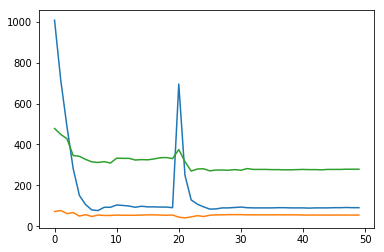

1


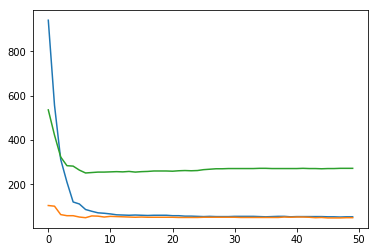

2


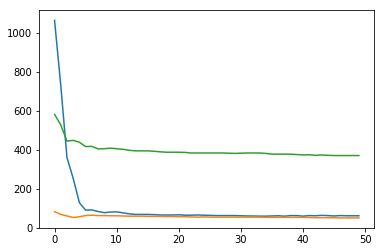

3


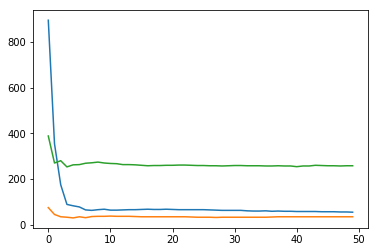

4


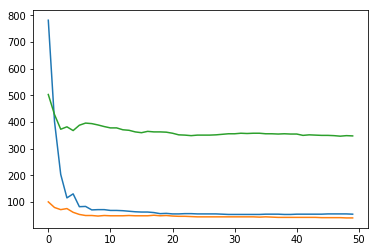

5


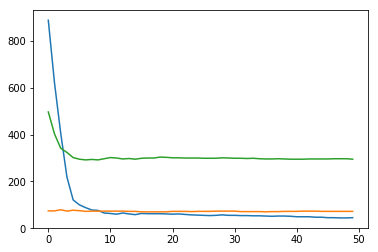

6


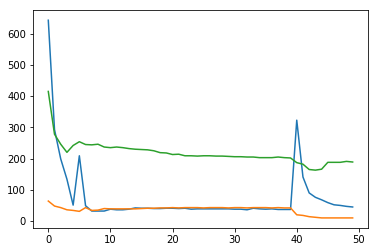

7


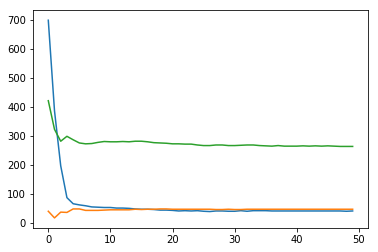

8


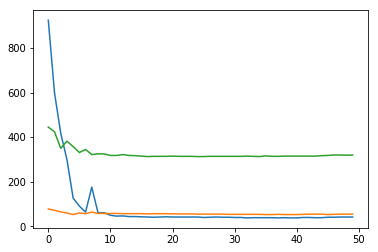

9


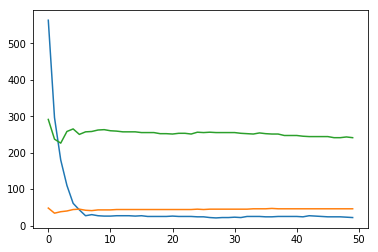

10


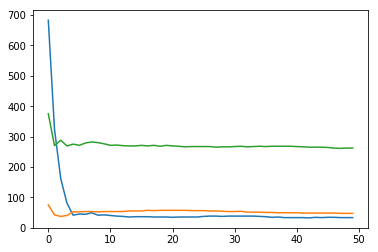

11


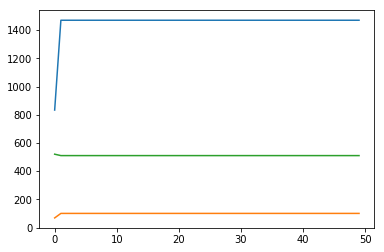

12


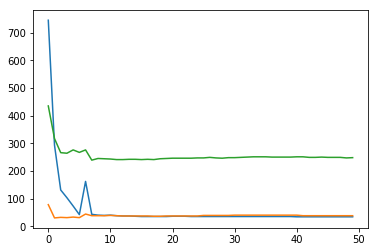

13


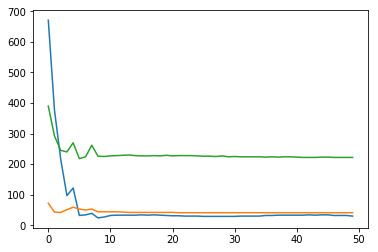

14


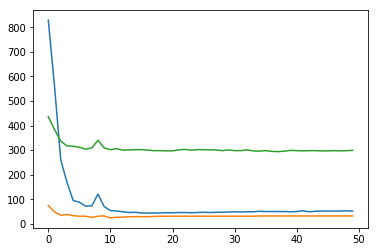

15


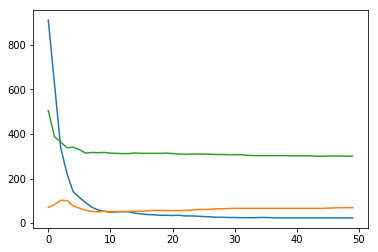

16


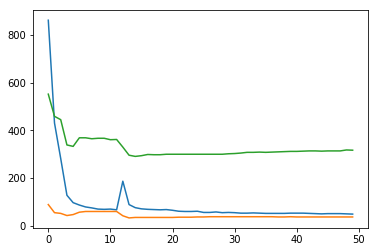

17


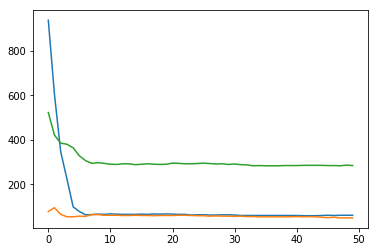

18


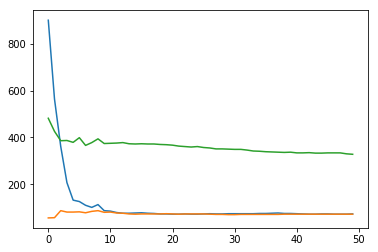

19


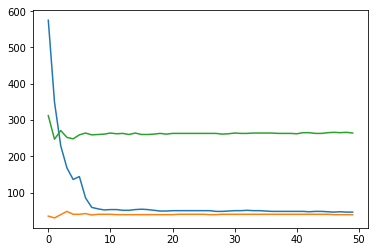

20


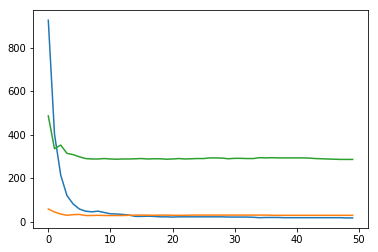

21


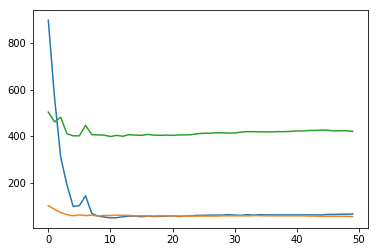

22


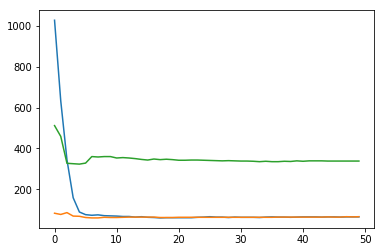

23


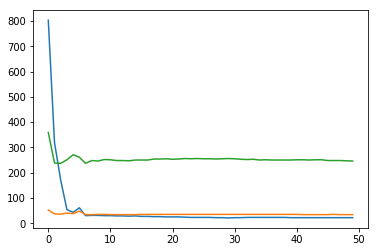

24


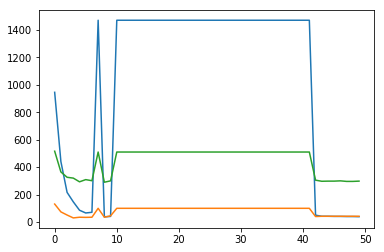

25


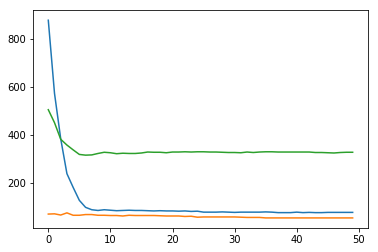

26


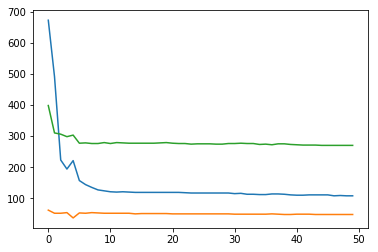

27


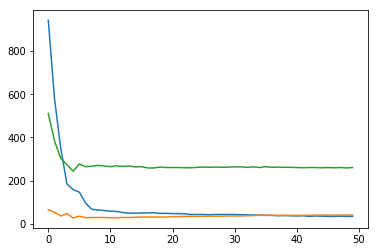

28


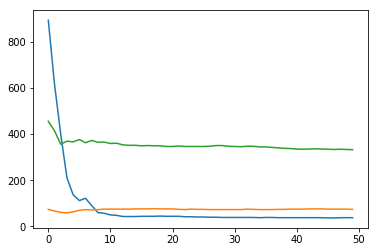

29


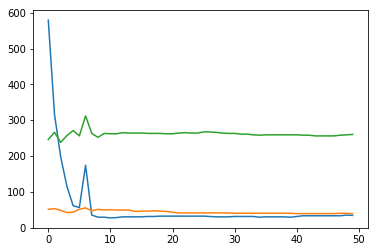

30


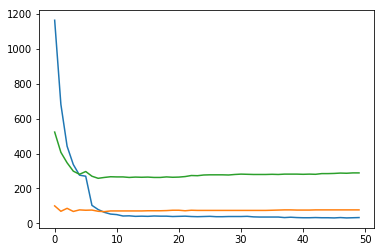

31


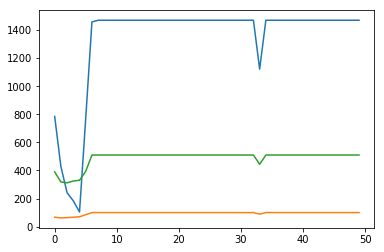

32


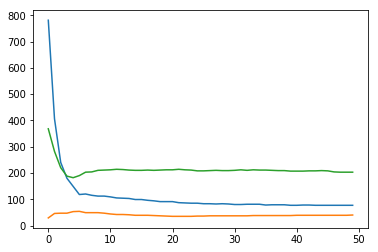

33


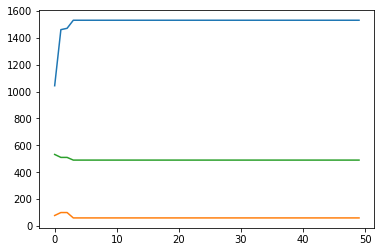

34


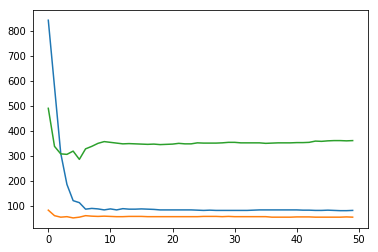

35


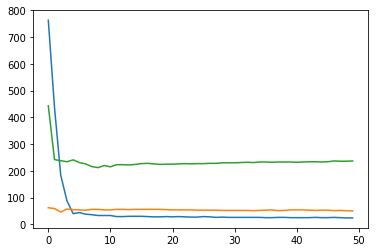

36


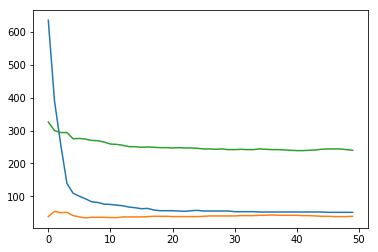

37


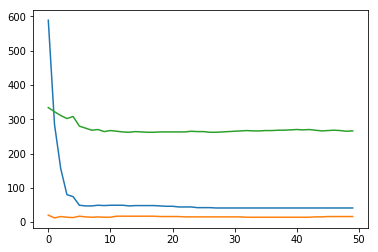

38


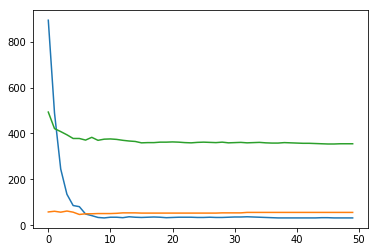

39


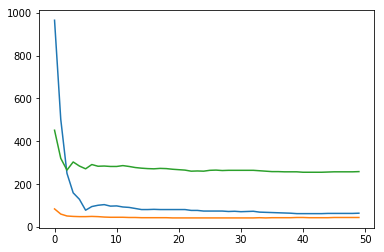

40


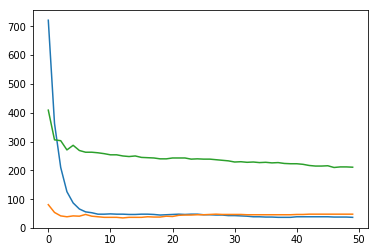

41


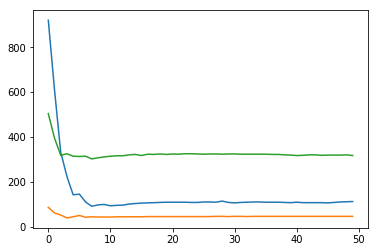

42


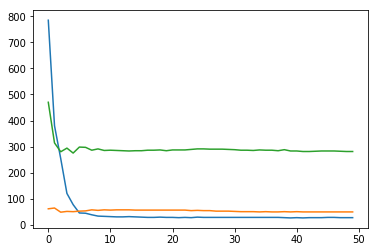

43


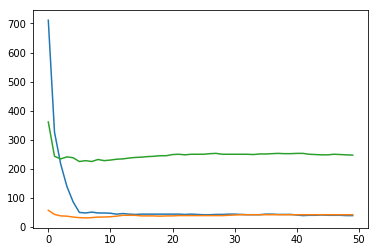

44


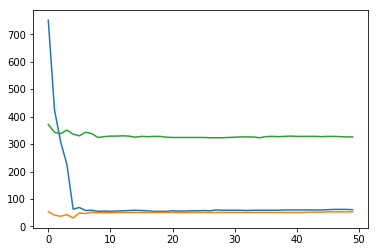

45


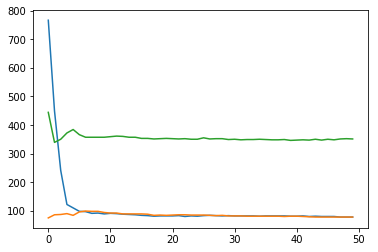

46


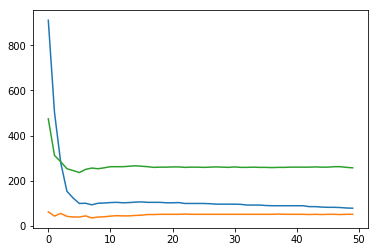

47


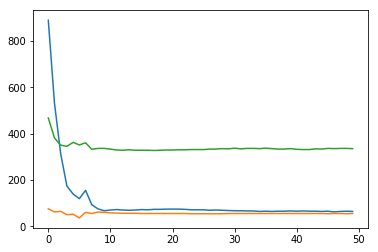

48


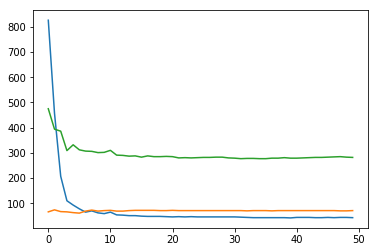

49


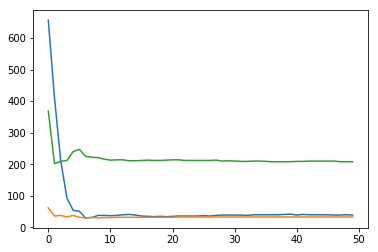

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


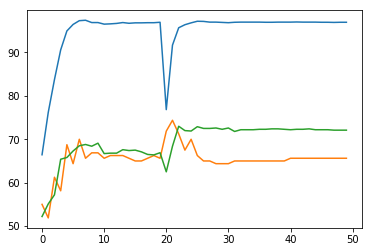

1


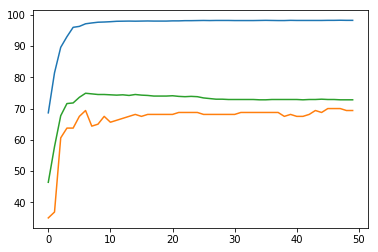

2


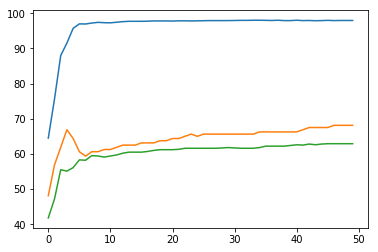

3


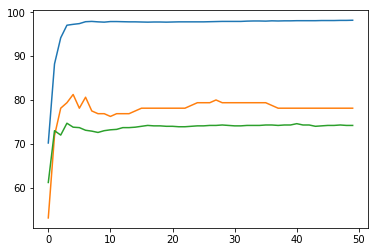

4


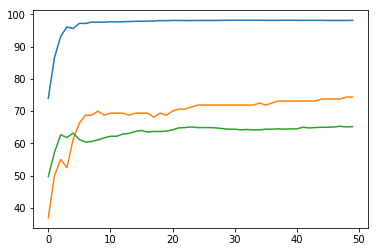

5


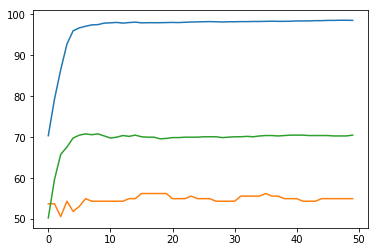

6


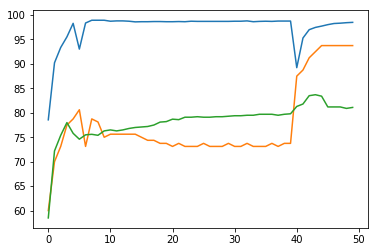

7


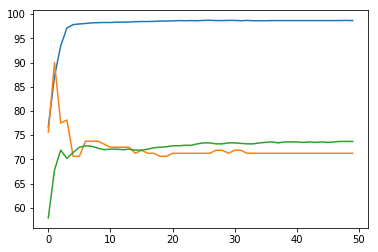

8


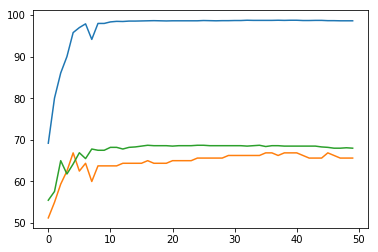

9


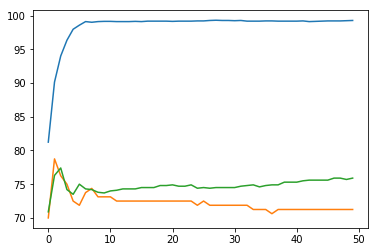

10


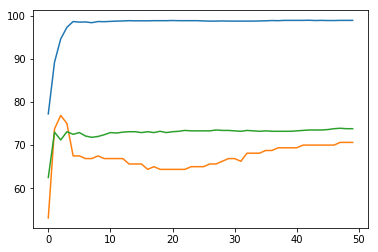

11


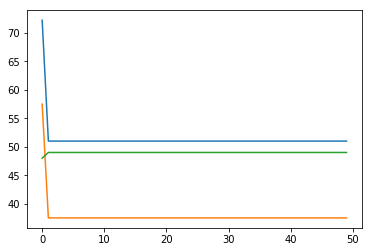

12


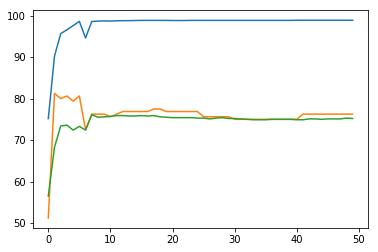

13


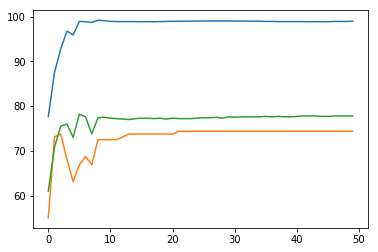

14


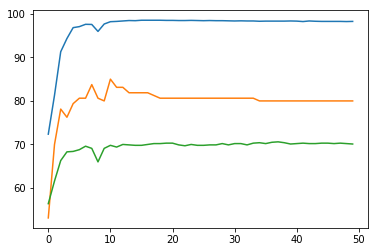

15


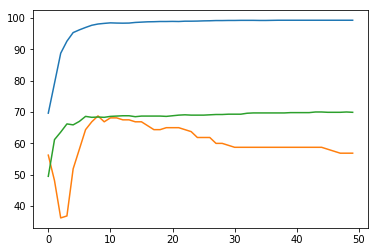

16


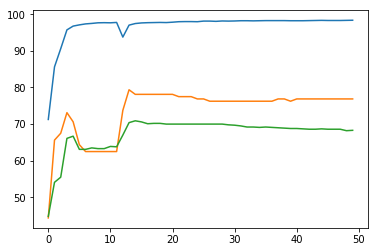

17


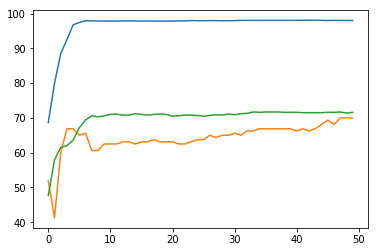

18


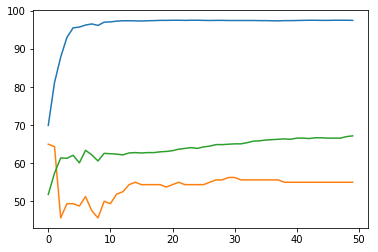

19


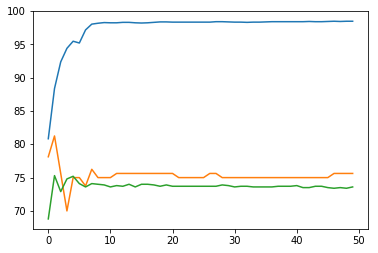

20


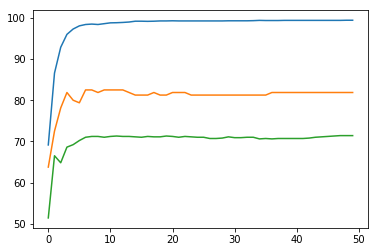

21


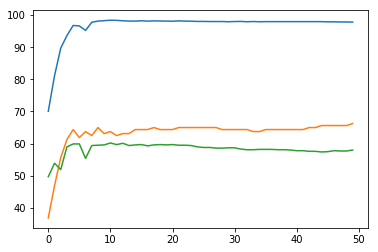

22


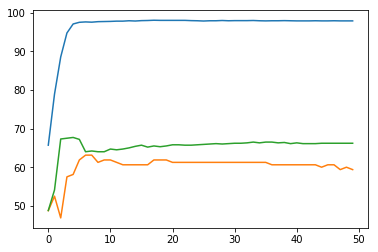

23


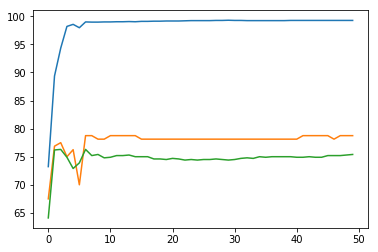

24


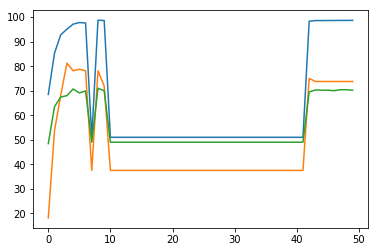

25


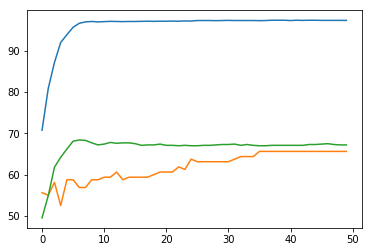

26


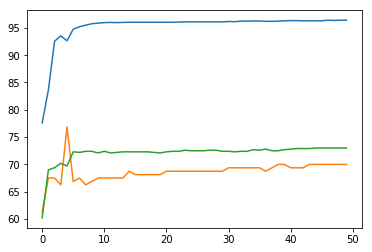

27


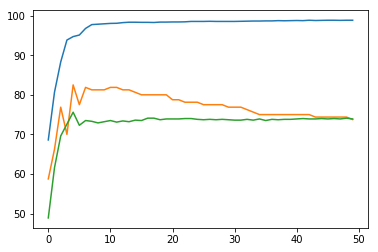

28


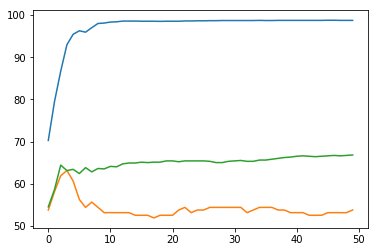

29


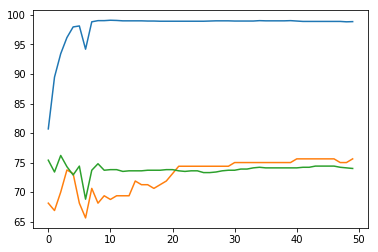

30


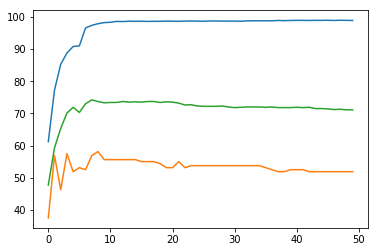

31


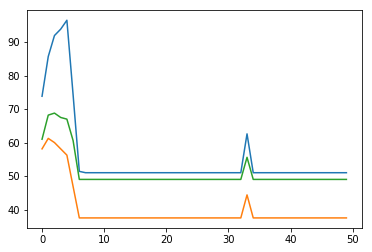

32


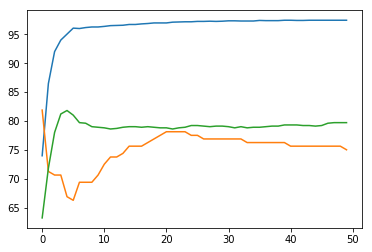

33


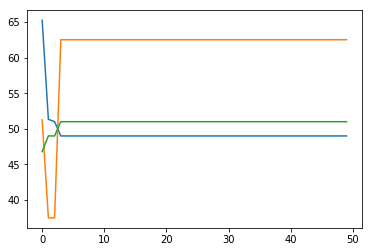

34


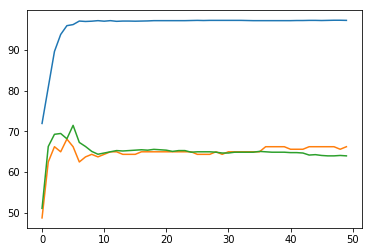

35


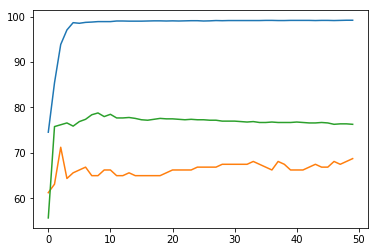

36


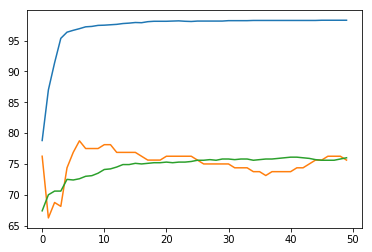

37


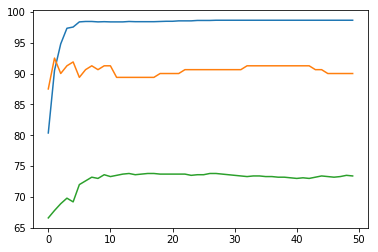

38


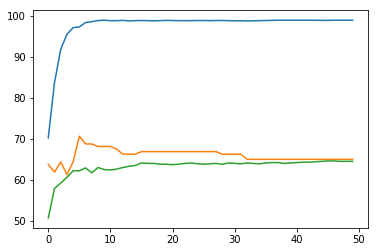

39


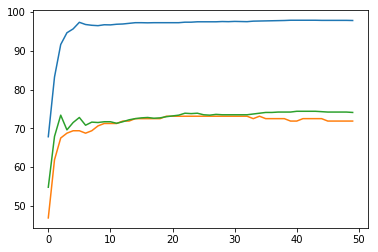

40


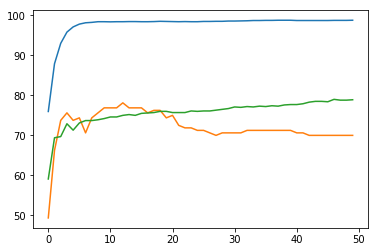

41


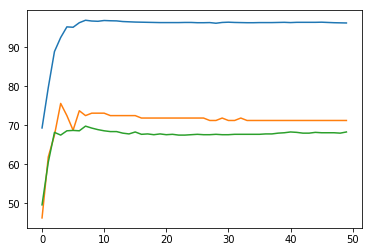

42


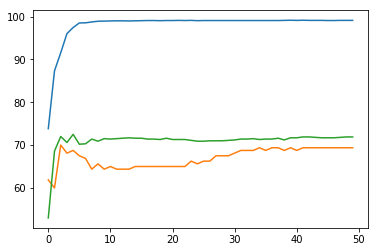

43


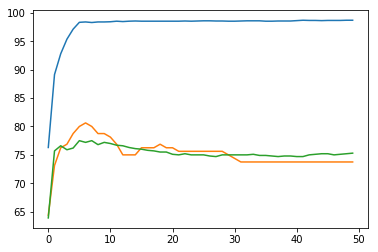

44


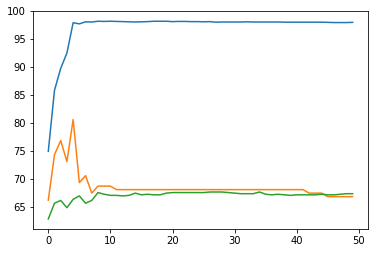

45


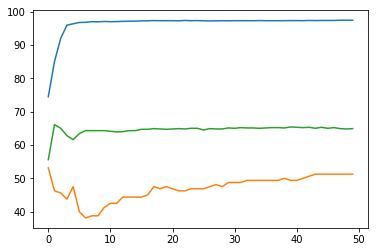

46


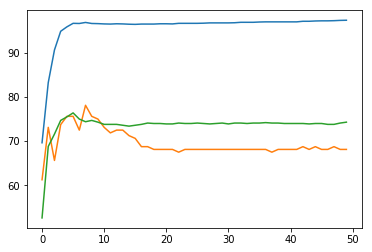

47


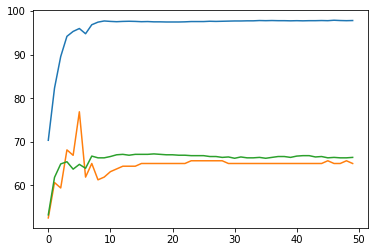

48


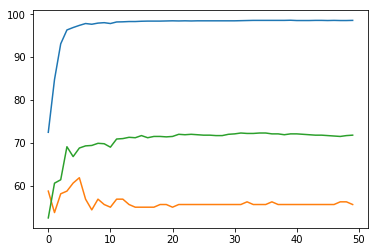

49


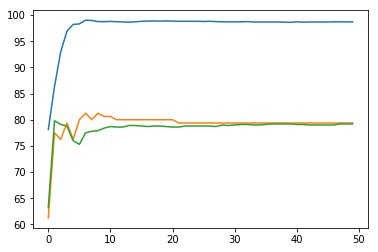

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)


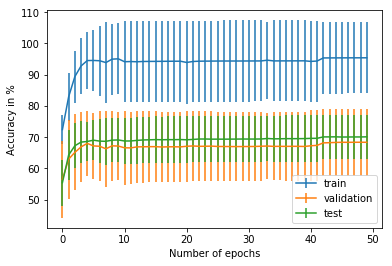

In [9]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
plt.errorbar(epoch, mean_test_errors, stddev_test_errors)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])